## Data Loadout

In [71]:
#Neural Network from Homework 6
#Import files first

In [72]:
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import pandas as pd
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

In [73]:
#Formatting data

In [74]:
lol_df = pd.read_csv('games.csv')
lol_df2 = lol_df[['gameDuration', 'winner','firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
lol_X = lol_df2[['gameDuration', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
lol_X = np.array(lol_X)
lol_Y = lol_df2[['winner']]
lol_Y = np.array(lol_Y)

print(lol_X)
print(lol_Y)

[[1949    2    1 ...    0    1    1]
 [1851    1    1 ...    0    0    0]
 [1493    2    1 ...    0    1    0]
 ...
 [2156    2    2 ...    0    2    0]
 [1475    2    2 ...    0    1    0]
 [1445    1    1 ...    0    1    0]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [75]:
#Scaling data

In [76]:
X_scale = StandardScaler()
lol_X_scale = X_scale.fit_transform(lol_X)

lol_X_scale[0,:] # Looking the new features after scaling

array([ 0.22780135,  1.01611295, -0.83013151, -0.45628079,  0.08734089,
       -0.77743196,  1.54200134,  1.39498948, -0.01387537,  2.78752472,
        1.33643434, -0.5796078 , -0.14231362, -0.78413297, -0.67541854,
       -0.33023792,  1.77900161])

In [77]:
#Splitting training/testing data 75/25.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(lol_X_scale, lol_Y, test_size = 0.75, train_size = 0.25)

## Neural Network Functions

In [79]:
#Setting up output layer, no need its not a multiclass classification problem.

In [80]:
#creating the actual neural network

In [81]:
#activation function

In [82]:
def f(z):
    #sigmoid
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    #sigmoid
    return f(z) * (1 - f(z))

In [83]:
#Creating and initializing W and b

In [84]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [85]:
#Initializing▿𝑊 and▿𝑏

In [86]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [87]:
#Feed forward

In [88]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [89]:
#Compute 𝛿

In [90]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [91]:
#Back propagation

In [92]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lambda_var=0.001):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%100 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            #W[l] += -alpha * (1.0/N * tri_W[l])
            #regularization
            W[l] += -alpha * ((1.0/N * tri_W[l]) + (lambda_var*W[l]))
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

## Neural Network with Sigmoid Function

In [93]:
#Running the neural network, plotting result and displaying accuracy.

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


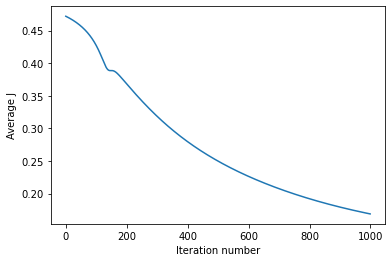

Prediction accuracy on training data is 50.31852082038534%
Prediction accuracy on testing data is 50.75353462116111%


In [94]:
nn_structure = [17, 15, 1]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, 1000)

# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred) * 100))

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred) * 100))

## Neural Network with Leaky ReLU

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


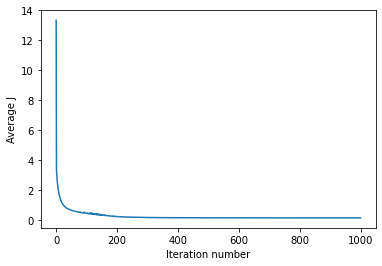

Prediction accuracy on training data is 50.31852082038534%
Prediction accuracy on testing data is 50.75353462116111%


In [95]:
# Redefining f(z) and f_deriv(z) to set activation function to Leaky ReLU

def f(z):
    # Leaky ReLU
    return np.maximum(0.01 * z, z)

def f_deriv(z):
    # Leaky ReLU
    z_ret = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] < 0:
            z_ret[i] = 0.01
        elif z[i] >= 0:
            z_ret[i] = 1
    return z_ret

# Running neural network, plotting cost, and displaying accuracy

nn_structure_lr = [17, 15, 1]
    
# train the NN
W_lr, b_lr, avg_cost_func_lr = train_nn(nn_structure_lr, X_train, y_train, 1000)

# plot the avg_cost_func
plt.plot(avg_cost_func_lr)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_lr = predict_y(W_lr, b_lr, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_lr) * 100))

y_pred_lr = predict_y(W_lr, b_lr, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_lr) * 100))